# DIPY do affine transformation for registering sMRI to dMRI

`05-diff-dipy-do-affine-reg-anat2dwi.ipynb` ver. 20200422

### Image registration between Freesurfer segmenations (in native space) and diffusion data using Dipy

Assuming `03-diff-dipy-find-affine-brainmask2dwi.ipynb` is run

Also assume that the images in the Freesurfer tree is transformed from Freesurfer space to native space using mri_vol2vol, e.g. 
- `sub_101_tp1_orig_in_native_space.nii.gz`, 
- `sub_101_tp1_brain_in_native_space.nii.gz`, 
- `sub_101_tp1_brainmask_in_native_space.nii.gz`, 
- `sub_101_tp1_ribbon_in_native_space.nii.gz`, 
- `sub_101_tp1_aseg_in_native_space.nii.gz`,
- `sub_101_tp1_wmparc_in_native_space.nii.gz`,
- `sub_101_tp1_aparc+aseg_in_native_space.nii.gz`,


(see end of  `03-diff-dipy-find-affine-brainmask2dwi.ipynb`)

See also https://bic-berkeley.github.io/psych-214-fall-2016/dipy_registration.html

DIPY is a free and open source software project for computational neuroanatomy, focusing mainly on diffusion magnetic resonance imaging (dMRI) analysis. It implements a broad range of algorithms for denoising, registration, reconstruction, tracking, clustering, visualization, and statistical analysis of MRI data.

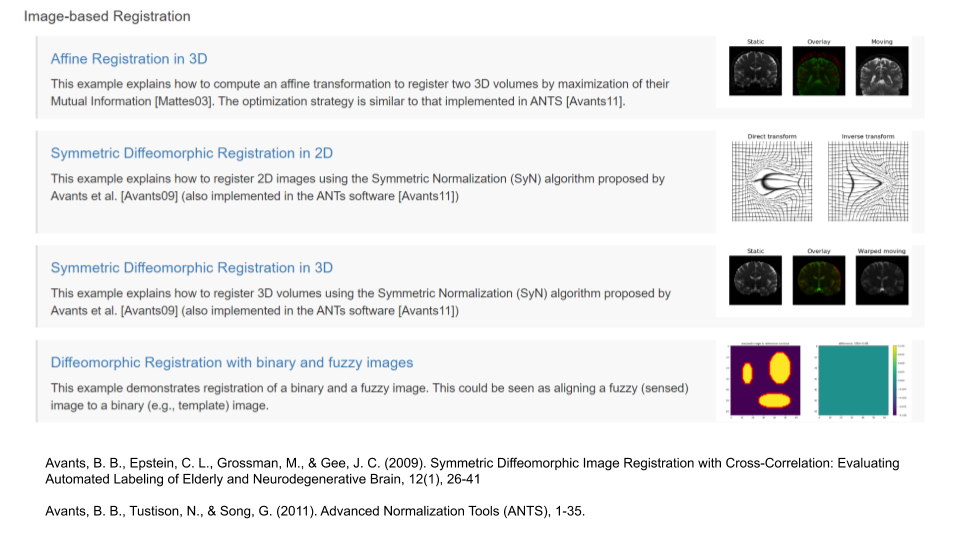

In [1]:
from IPython.display import Image
Image("assets/dipy_image_registration_ants.png")

### Install

How to install [dipy](https://dipy.org)

 * https://dipy.org/documentation/1.0.0./installation

### Usage

https://dipy.org/tutorials

## Make an affine registration when the affine map is computed previuously 

In [2]:
import os
import pathlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
from os.path import expanduser, join, basename, split
home = expanduser('~') # To make path to local home directory
import time
from dipy.viz import regtools
from dipy.align.imaffine import (AffineMap, MutualInformationMetric, AffineRegistration)
from dipy.align.transforms import (TranslationTransform3D, RigidTransform3D, AffineTransform3D)
from dipy.io.image import save_nifti

/home/arvid/anaconda3/envs/bmed360v2020/lib/python3.7/site-packages/dipy/viz/__init__.py:22: UserWarning: You do not have FURY installed. Some visualization functions might not work for you. For installation instructions, please visit: https://fury.gl/
  "You do not have FURY installed. "


In [3]:
def do_affine_reg_anat2dwi(inpdir, sub, ses, outdir):
    r"""
    Affine registration between a Freesurfer segmented region or mask and a mean S0 in native DWI space using multilevel optimization and the 
    Mutual Information similarity measure. Based on the affine map obtained from '03-diff-dipy-find-affine-brainmask2dwi.ipynb'

    Parameters
    ----------
    inpdir     : input directory e.g. inpdir = './data/dipy_analysis' where the moving files from Freesurfer segmentation mapped to T1w native space are stored.
    sub        : subject id, e.g. 101 for sub-101
    ses        : session number, eg 1 for ses-1
    outdir     : output directory e.g. outdir = inpdir, where resulting affinely transformed input moving image are stored,

    Returns
    -------
    NIL


    Notes
    -----
    
    The affine map is saved by '03-diff-dipy-find-affine-brainmask2dwi.ipynb':
        np.savetxt(affine_fn, affine.get_affine(), delimiter=',')  
    and loaded by:  
        aff = np.loadtxt(affine_fn, delimiter=',')
        affine_map = AffineMap(np.eye(4))
        affine_map.set_affine(aff)

    """
    
    # Preparations

    # Load static image in DWI native space
    static_fn = join(inpdir, 'sub_%d_tp%d_dwi_S0_mean.nii.gz' % (sub, ses))
    static_img= nib.load(static_fn)
    static_data = static_img.get_fdata()
    static_affine = static_img.affine
    
    # Load affine map: 
    affine_fn = join(inpdir, 'sub_%d_tp%d_affine_T1_biascorr_brain_to_dwi_S0_mean.mat' % (sub, ses))
    aff = np.loadtxt(affine_fn, delimiter=',')
    #affine_map = AffineMap(np.eye(4))
    #affine_map.set_affine(aff)
    
    
    # Load Freesurfer-segmented results in native anatomical space
    
    targ_name = 'native_space'
    
    # Images (linear interpolation)
    fs_img = ['orig', 'brain']
    for i, ima in enumerate(fs_img):
        moving_ima_fn = join(inpdir,'sub_%d_tp%d_%s_in_%s.nii.gz' % (sub, ses, ima, targ_name))
        moving_ima = nib.load(moving_ima_fn)
        moving_ima_data = moving_ima.get_fdata()
        moving_ima_affine = moving_ima.affine
        
        affine_map = AffineMap(affine=np.eye(4),    # identity
                           domain_grid_shape=static_data.shape, 
                           domain_grid2world=static_affine,
                           codomain_grid_shape=moving_ima_data.shape, 
                           codomain_grid2world=moving_ima_affine)
        affine_map.set_affine(aff)
        
        transformed_ima = affine_map.transform(
        image=moving_ima_data,
        interp='linear', # 'linear' (k-linear interpoltaion) or 'nearest'
        image_grid2world=None,
        sampling_grid_shape=None,
        sampling_grid2world=None,
        resample_only=False
        )
    
        transformed_ima_fn = join(outdir, 'sub_%d_tp%d_%s_in_native_space_aff_to_dwi_S0_mean.nii.gz' % (sub, ses, ima))
        moving2static_ima = nib.Nifti1Image(transformed_ima, static_affine)
        nib.save(moving2static_ima, transformed_ima_fn)
    
    
    # Masks (nearest neighbour interpolation)
    fs_msk = ['brainmask', 'ribbon', 'aseg', 'wmparc', 'aparc+aseg']
    for i, segm in enumerate(fs_msk):
        moving_mask_fn = join(inpdir,'sub_%d_tp%d_%s_in_%s.nii.gz' % (sub, ses, segm, targ_name))
        moving_mask = nib.load(moving_mask_fn)
        moving_mask_data = moving_mask.get_fdata()
        moving_mask_affine = moving_mask.affine
        
        affine_map = AffineMap(affine=np.eye(4),    # identity
                           domain_grid_shape=static_data.shape, 
                           domain_grid2world=static_affine,
                           codomain_grid_shape=moving_mask_data.shape, 
                           codomain_grid2world=moving_mask_affine)
        affine_map.set_affine(aff)
        
        transformed_mask = affine_map.transform(
        image=moving_mask_data,
        interp='nearest', # 'linear' (k-linear interpoltaion) or 'nearest'
        image_grid2world=None,
        sampling_grid_shape=None,
        sampling_grid2world=None,
        resample_only=False
        )
    
        transformed_mask_fn = join(outdir, 'sub_%d_tp%d_%s_in_native_space_aff_to_dwi_S0_mean.nii.gz' % (sub, ses, segm))
        moving2static_mask = nib.Nifti1Image(transformed_mask, static_affine)
        nib.save(moving2static_mask, transformed_mask_fn)
           
    
    return


### Test the function

In [4]:
working_dir = join(os.getcwd(), 'data')
inp_dir = '%s/dipy_analysis' % (working_dir)
outp_dir = inp_dir
sub = 101
ses = 1

In [5]:
%%time
do_affine_reg_anat2dwi(inp_dir, sub, ses, outp_dir)

CPU times: user 21.6 s, sys: 473 ms, total: 22.1 s
Wall time: 1.81 s


In [6]:
#do_affine_reg_anat2dwi?

## Run for all subjects

In [7]:
import sys
sys.path.append('.')   # path to utils.py
import utils
import time

working_dir = join(os.getcwd(), 'data')
inp_dir = '%s/dipy_analysis' % (working_dir)
outp_dir = inp_dir

In [8]:
%%time
nsubj = 1 # 30
ses=1

for i in utils.progressbar(range(nsubj), "Computing: ", 40):
    time.sleep(0.1)
    sub = i+101
    
    do_affine_reg_anat2dwi(inp_dir, sub, ses, outp_dir)


Computing: [########################################] 1/1
CPU times: user 23.5 s, sys: 560 ms, total: 24.1 s
Wall time: 1.88 s
